# 第2部　Pythonによる時系列分析の基本

## 第5章　Pythonによる時系列分析の基本

### 分析の準備

In [1]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd

# グラフを描画するライブラリ
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set()

# 統計モデルを推定するライブラリ
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as tsa

# グラフの日本語表記
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Meiryo'

# DataFrameの全角文字の出力をきれいにする
pd.set_option('display.unicode.east_asian_width', True)

In [2]:
# 表示設定
np.set_printoptions(linewidth=80)
pd.set_option('display.width', 80)

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4

### 飛行機乗客数データの読み込み

In [3]:
# 飛行機乗客数データの読み込み
air_passengers = sm.datasets.get_rdataset("AirPassengers").data

# 日付インデックスの作成
date_index = pd.date_range(
    start='1949-01-01', periods=len(air_passengers), freq='MS')
air_passengers.index = date_index

# 不要な時間ラベルの削除
air_passengers = air_passengers.drop(air_passengers.columns[0], axis=1)

# 結果の確認
print(air_passengers.head(3))

            value
1949-01-01    112
1949-02-01    118
1949-03-01    132


### 時系列折れ線グラフの作成

#### pandasのplotメソッドの利用

<Axes: >

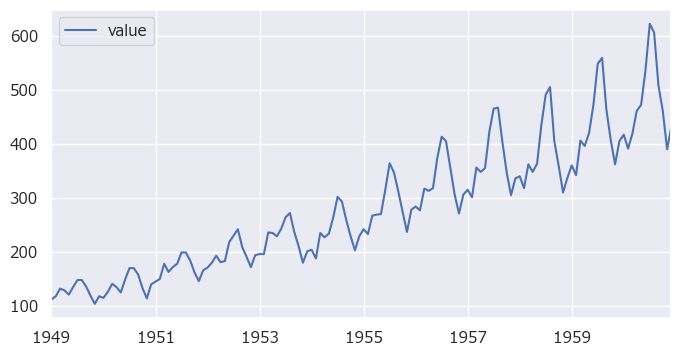

In [4]:
# 時系列折れ線グラフの作成
air_passengers.plot()

#### matplotlibとseabornの利用

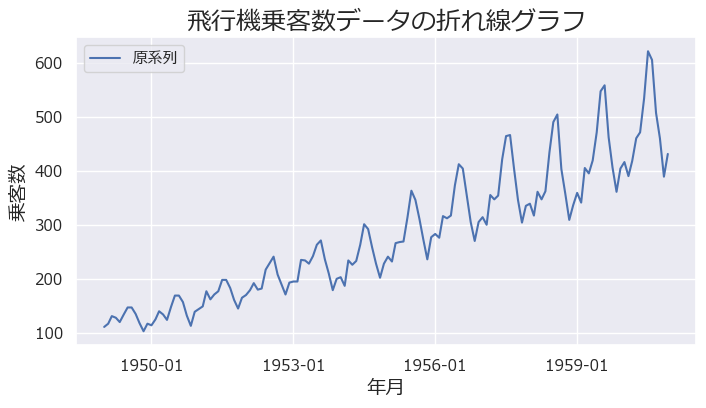

In [5]:
# グラフサイズの指定
fig, ax = plt.subplots(figsize=(8, 4))

# 折れ線グラフを描く
ax.plot(air_passengers['value'], label='原系列')

# 軸ラベルとタイトル・凡例
ax.set_xlabel('年月', size=14)
ax.set_ylabel('乗客数', size=14)
ax.set_title('飛行機乗客数データの折れ線グラフ', size=18)
ax.legend()

# 軸の指定
# 3年ごとに軸を載せる
# DayLocator / MonthLocator / YearLocator
ax.xaxis.set_major_locator(mdates.YearLocator(3))

# 軸ラベルのフォーマット
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

### データのシフト（ラグ）

In [6]:
# データをコピー
air_passengers_lag = air_passengers.copy()

# シフトした結果をlag1列として追加
air_passengers_lag['lag1'] = air_passengers_lag['value'].shift(1)

# 結果の確認
print(air_passengers_lag.head(3))
print(air_passengers_lag.tail(3))

            value   lag1
1949-01-01    112    NaN
1949-02-01    118  112.0
1949-03-01    132  118.0
            value   lag1
1960-10-01    461  508.0
1960-11-01    390  461.0
1960-12-01    432  390.0


In [7]:
# さまざまな次数でラグをとる
air_passengers_lag['lag2'] = air_passengers_lag['value'].shift(2)
air_passengers_lag['lead1'] = air_passengers_lag['value'].shift(-1)

# 結果の確認
print(air_passengers_lag.head(3))
print(air_passengers_lag.tail(3))

            value   lag1   lag2  lead1
1949-01-01    112    NaN    NaN  118.0
1949-02-01    118  112.0    NaN  132.0
1949-03-01    132  118.0  112.0  129.0
            value   lag1   lag2  lead1
1960-10-01    461  508.0  606.0  390.0
1960-11-01    390  461.0  508.0  432.0
1960-12-01    432  390.0  461.0    NaN


### 増減量と差分系列

#### 差分系列の取得

In [8]:
# 差分値をとる
diff_value = air_passengers_lag['value'] - air_passengers_lag['value'].shift(1)
diff_value.head(3)

1949-01-01     NaN
1949-02-01     6.0
1949-03-01    14.0
Freq: MS, Name: value, dtype: float64

In [9]:
# データをコピー
air_passengers_diff = air_passengers.copy()

# 差分系列
air_passengers_diff['diff1'] = air_passengers_diff['value'].diff(1)

# 結果の確認
print(air_passengers_diff.head(3))
print(air_passengers_diff.tail(3))

            value  diff1
1949-01-01    112    NaN
1949-02-01    118    6.0
1949-03-01    132   14.0
            value  diff1
1960-10-01    461  -47.0
1960-11-01    390  -71.0
1960-12-01    432   42.0


### 前年差と季節差分系列

#### 季節差分系列

In [10]:
# 季節差分
air_passengers_diff['diff12'] = air_passengers_diff['value'].diff(12)

<Axes: >

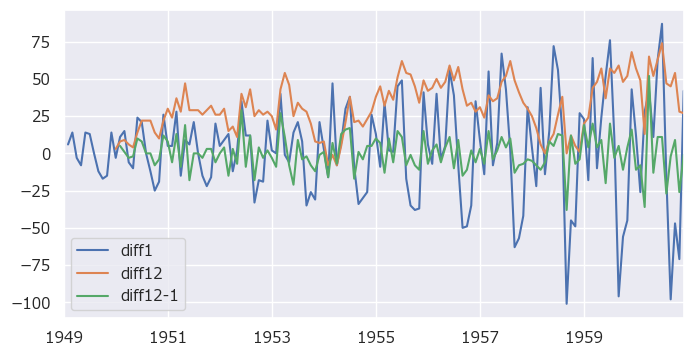

In [11]:
# 季節差分系列に対して、さらに差分をとる
air_passengers_diff['diff12-1'] = air_passengers_diff['diff12'].diff(1)

# 時系列折れ線グラフの作成
air_passengers_diff[['diff1', 'diff12', 'diff12-1']].plot()

In [12]:
# 参考：差分をとる順番は関係ない
air_passengers_diff['diff1-12'] = air_passengers_diff['diff1'].diff(12)

all(air_passengers_diff['diff12-1'].dropna() == air_passengers_diff['diff1-12'].dropna())

True

### 対数系列

#### 対数系列の取得

<Axes: >

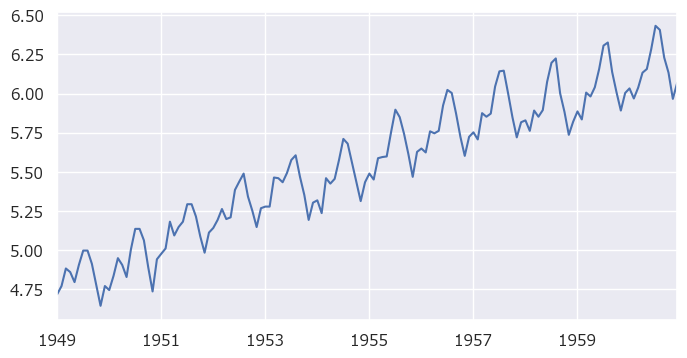

In [13]:
# データをコピー
air_passengers_log = air_passengers.copy()

# 対数変換
air_passengers_log['log'] = air_passengers_log['value'].apply(np.log)

# 時系列折れ線グラフの作成
air_passengers_log['log'].plot()

In [14]:
# 対数変換をもとに戻す
air_passengers_log['log'].apply(np.exp).head(3)

1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
Freq: MS, Name: log, dtype: float64

### 増減率と対数差分系列

#### 対数差分系列と対数季節差分系列の取得

In [15]:
# 対数差分系列
air_passengers_log['log_diff1'] = air_passengers_log['log'].diff(1)

# 対数季節差分系列
air_passengers_log['log_diff12'] = air_passengers_log['log'].diff(12)

<Axes: >

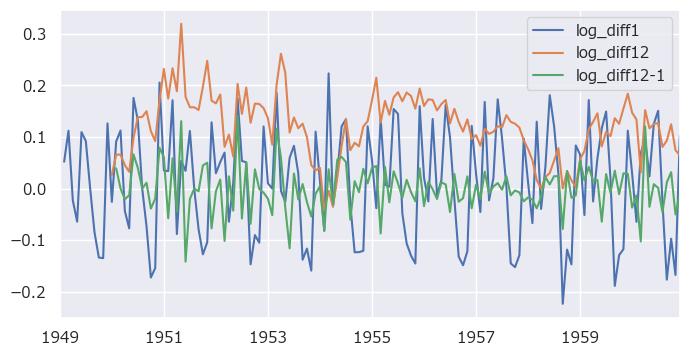

In [16]:
# 対数季節差分系列に対して、さらに差分をとる
air_passengers_log['log_diff12-1'] = air_passengers_log['log_diff12'].diff(1)

# 時系列折れ線グラフの作成
air_passengers_log[['log_diff1', 'log_diff12', 'log_diff12-1']].plot()

### 自己相関係数とコレログラム

#### 自己相関係数とコレログラム

In [17]:
# 自己相関係数
tsa.acf(air_passengers['value'], nlags=12)

array([1.        , 0.94804734, 0.87557484, 0.80668116, 0.75262542, 0.71376997,
       0.6817336 , 0.66290439, 0.65561048, 0.67094833, 0.70271992, 0.74324019,
       0.76039504])

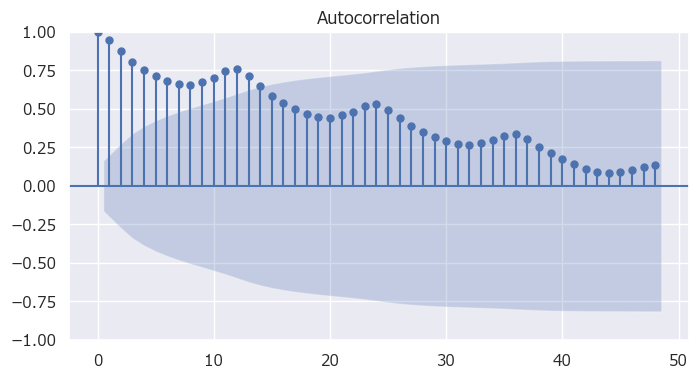

In [18]:
# コレログラム
_ = sm.graphics.tsa.plot_acf(air_passengers['value'], lags=48)

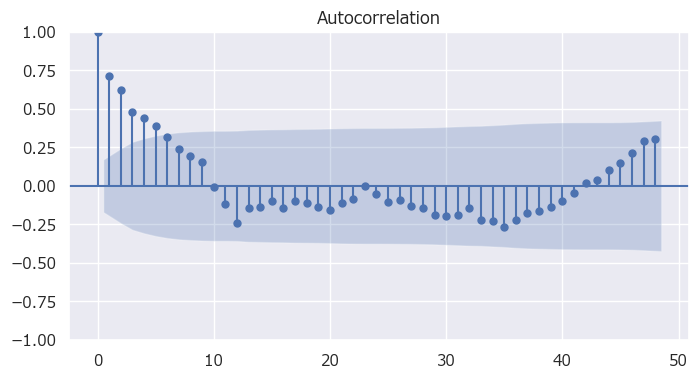

In [19]:
# 対数差分系列のコレログラム
_ = sm.graphics.tsa.plot_acf(
    air_passengers_log['log_diff12'].dropna(), lags=48)

#### 自己相関のイメージ

<Axes: xlabel='value', ylabel='value'>

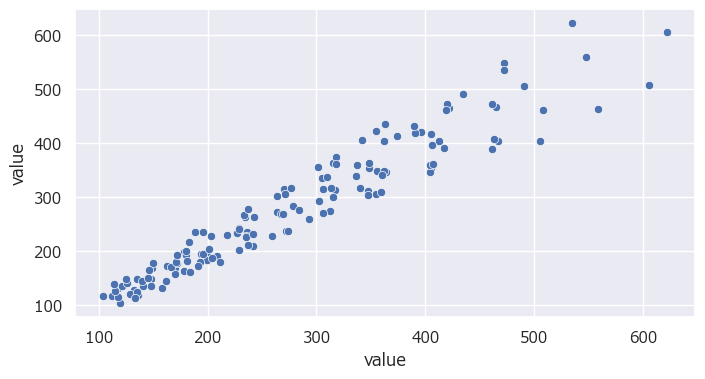

In [20]:
# 正の自己相関のイメージ
sns.scatterplot(x=air_passengers['value'].shift(1), 
                y=air_passengers['value'])

<Axes: xlabel='log_diff12', ylabel='log_diff12'>

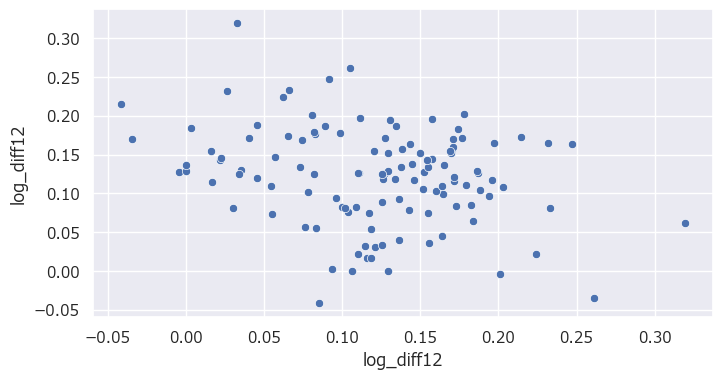

In [21]:
# 参考：負の自己相関のイメージ
sns.scatterplot(x=air_passengers_log['log_diff12'].shift(12), 
                y=air_passengers_log['log_diff12'])

#### 偏自己相関係数

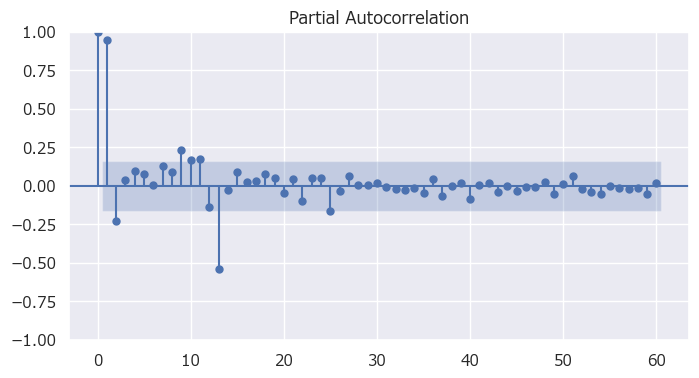

In [22]:
# 偏自己相関係数のコレログラム
_ = sm.graphics.tsa.plot_pacf(air_passengers['value'], lags=60, method='ywm')

### 移動平均

In [23]:
# データをコピー
air_passengers_ma = air_passengers.copy()

# 5時点の移動平均
air_passengers_ma['ma5'] = air_passengers_ma['value'].rolling(
    window=5).mean()

# 5時点の移動平均において、当該時点を中心にする
air_passengers_ma['ma5_center'] = air_passengers_ma['value'].rolling(
    window=5, center=True).mean()

# 結果の確認
print(air_passengers_ma.head(6))

            value    ma5  ma5_center
1949-01-01    112    NaN         NaN
1949-02-01    118    NaN         NaN
1949-03-01    132    NaN       122.4
1949-04-01    129    NaN       127.0
1949-05-01    121  122.4       133.0
1949-06-01    135  127.0       136.2


### 偶数個の移動平均の注意点

#### 通常の4時点移動平均の問題

In [24]:
# 4時点移動平均
air_passengers_ma['ma4_center'] = air_passengers_ma['value'].rolling(
    window=4, center=True).mean()

print(air_passengers_ma[['value', 'ma4_center']].head(4))
print(air_passengers_ma[['value', 'ma4_center']].tail(4))

            value  ma4_center
1949-01-01    112         NaN
1949-02-01    118         NaN
1949-03-01    132      122.75
1949-04-01    129      125.00
            value  ma4_center
1960-09-01    508      549.25
1960-10-01    461      491.25
1960-11-01    390      447.75
1960-12-01    432         NaN


#### 正しい重みづけ

In [25]:
# 加重平均の重み
weight = np.concatenate([np.array([1/8]), np.tile(1/4, 3), np.array([1/8])])
weight

array([0.125, 0.25 , 0.25 , 0.25 , 0.125])

In [26]:
# 1949年3月の加重移動平均値
np.average(air_passengers_ma['value'].loc['1949-01':'1949-05'],
           weights=weight)

123.875

In [27]:
# 加重平均をまとめて計算
true_ma4 = air_passengers_ma['value'].rolling(
    window=5, center=True).apply(np.average, kwargs={'weights': weight})
true_ma4.head(5)

1949-01-01        NaN
1949-02-01        NaN
1949-03-01    123.875
1949-04-01    127.125
1949-05-01    131.250
Freq: MS, Name: value, dtype: float64

#### 中心化移動平均の効率的な実装

In [28]:
# 単純な4月移動平均に対して、さらに移動平均をとる
air_passengers_ma['true_ma4'] = \
    air_passengers_ma['ma4_center'].rolling(window=2).mean().shift(-1)

print(air_passengers_ma.head(4))
print(air_passengers_ma.tail(4))

            value  ma5  ma5_center  ma4_center  true_ma4
1949-01-01    112  NaN         NaN         NaN       NaN
1949-02-01    118  NaN         NaN         NaN       NaN
1949-03-01    132  NaN       122.4      122.75   123.875
1949-04-01    129  NaN       127.0      125.00   127.125
            value    ma5  ma5_center  ma4_center  true_ma4
1960-09-01    508  548.6       517.4      549.25    520.25
1960-10-01    461  546.4       479.4      491.25    469.50
1960-11-01    390  517.4         NaN      447.75       NaN
1960-12-01    432  479.4         NaN         NaN       NaN


In [29]:
# 参考：2つの方法で求めた中心化移動平均の比較
np.all((air_passengers_ma['true_ma4'].dropna() == true_ma4.dropna())**2)

True

#### 12時点中心化移動平均

<Axes: >

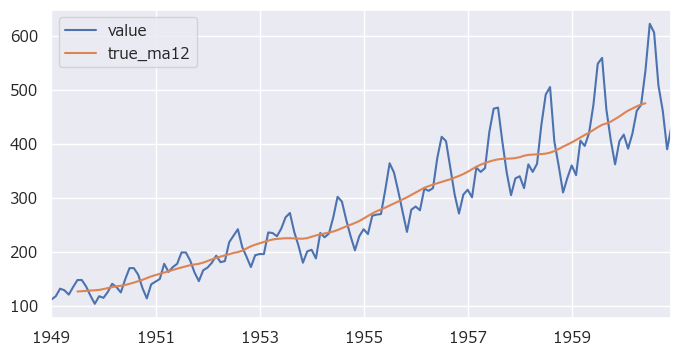

In [30]:
# 12時点移動平均
air_passengers_ma['ma12_center'] = air_passengers_ma['value'].rolling(
    window=12, center=True).mean()

# 単純な12月移動平均に対して、さらに移動平均をとる
# これが中心化移動平均となる
air_passengers_ma['true_ma12'] = \
    air_passengers_ma['ma12_center'].rolling(window=2).mean().shift(-1)

# 原系列と12時点移動平均の比較
air_passengers_ma[['value', 'true_ma12']].plot()

### 月次の気温データの分析例
https://www.data.jma.go.jp/risk/obsdl/index.php

In [31]:
# CSVファイルの読み込み
weather_month = pd.read_csv(
    '2-5-1-weather-month.csv',
    index_col='年月',
    parse_dates=True,
    dtype='float'
)

# 頻度の指定
weather_month.index.freq = 'MS'

# 最初と最後の3行の表示
print(weather_month.head(3))
print(weather_month.tail(3))

            平均気温(℃)  日最高気温35℃以上日数(日)
年月                                              
1900-01-01          1.6                        0.0
1900-02-01          3.1                        0.0
1900-03-01          5.7                        0.0
            平均気温(℃)  日最高気温35℃以上日数(日)
年月                                              
2021-10-01         18.2                        0.0
2021-11-01         13.7                        0.0
2021-12-01          7.9                        0.0


<Axes: xlabel='年月'>

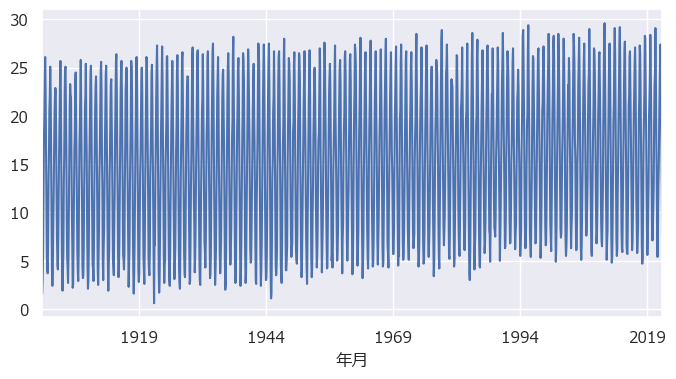

In [32]:
weather_month['平均気温(℃)'].plot()

### データの取得頻度の変更

#### 1年間における35℃以上の日数

In [33]:
# 1年における35℃以上日数の取得
weather_year = weather_month.resample('YS').sum()

# 不要な列の削除
weather_year = weather_year.drop('平均気温(℃)', axis=1)

# 結果の確認
print(weather_year.head(3))
print(weather_year.tail(3))

            日最高気温35℃以上日数(日)
年月                                 
1900-01-01                        1.0
1901-01-01                        1.0
1902-01-01                        0.0
            日最高気温35℃以上日数(日)
年月                                 
2019-01-01                       12.0
2020-01-01                       12.0
2021-01-01                        2.0


<Axes: title={'center': '日最高気温35℃以上日数'}, xlabel='年', ylabel='日数'>

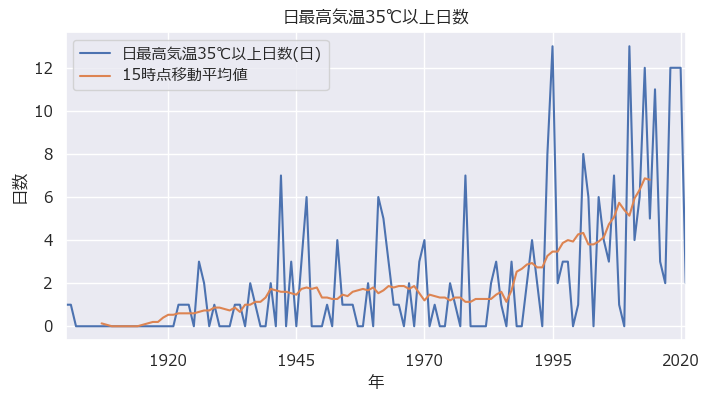

In [34]:
# 15時点移動平均
weather_year['15時点移動平均値'] = \
    weather_year['日最高気温35℃以上日数(日)'].rolling(
        window=15, center=True).mean()

# 時系列折れ線グラフの作成
weather_year[['日最高気温35℃以上日数(日)', '15時点移動平均値']].plot(
    title='日最高気温35℃以上日数', xlabel='年', ylabel='日数')

#### 月平均気温の年間平均値

<Axes: title={'center': '月平均気温の年間平均値'}, xlabel='年', ylabel='気温(℃)'>

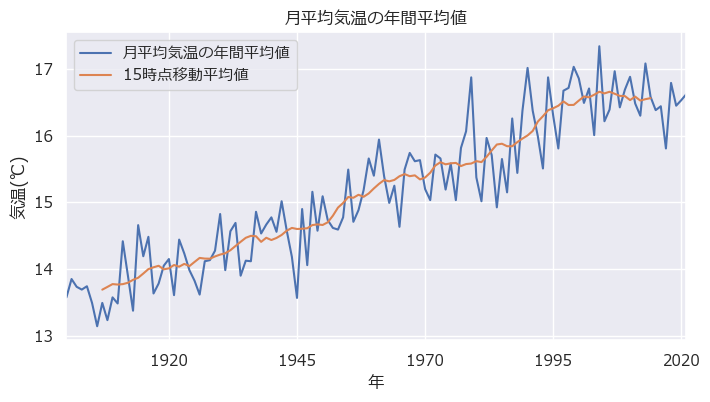

In [35]:
# 月平均気温の年間平均値の取得
weather_year['月平均気温の年間平均値'] = \
    weather_month['平均気温(℃)'].resample('YS').mean()

# 15時点移動平均値の取得
weather_year['15時点移動平均値'] = \
    weather_year['月平均気温の年間平均値'].rolling(
        window=15, center=True).mean()

# 時系列折れ線グラフの作成
weather_year[['月平均気温の年間平均値', '15時点移動平均値']] .plot(
    title='月平均気温の年間平均値', xlabel='年', ylabel='気温(℃)')

#### その他の集計方法

<Axes: title={'center': '月平均気温の年間最大値'}, xlabel='年月'>

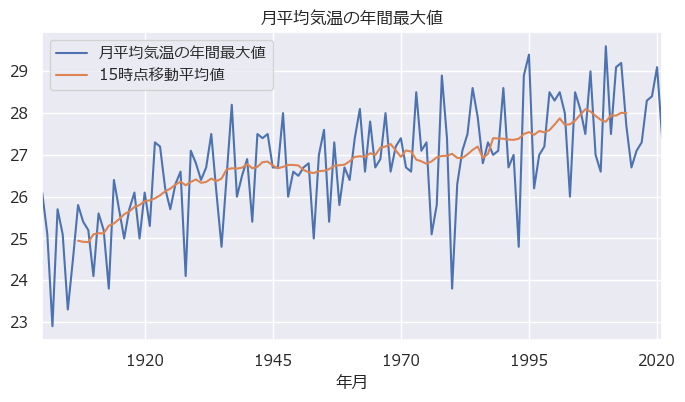

In [36]:
# 参考

# 月平均気温の年間最大値の取得
weather_year['月平均気温の年間最大値'] = weather_month['平均気温(℃)'].resample('YS').max()

# 15時点移動平均値の取得
weather_year['15時点移動平均値'] = weather_year['月平均気温の年間最大値'].rolling(
    window=15, center=True).mean()

# 時系列折れ線グラフの作成
weather_year[['月平均気温の年間最大値', '15時点移動平均値']].plot(title='月平均気温の年間最大値')

<Axes: title={'center': '月平均気温の年間最小値'}, xlabel='年月'>

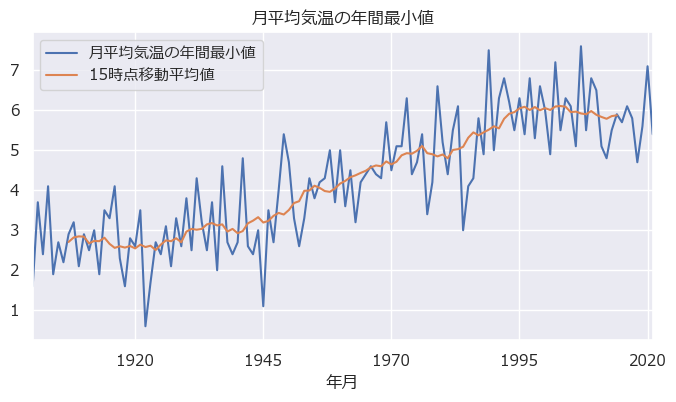

In [37]:
# 参考

# 月平均気温の年間最小値の取得
weather_year['月平均気温の年間最小値'] = weather_month['平均気温(℃)'].resample('YS').min()

# 15時点移動平均値の取得
weather_year['15時点移動平均値'] = weather_year['月平均気温の年間最小値'].rolling(
    window=15, center=True).mean()

# 時系列折れ線グラフの作成
weather_year[['月平均気温の年間最小値', '15時点移動平均値']] .plot(title='月平均気温の年間最小値')